In [83]:
%ssh = ncread('alt_sla_1x1_93_18.nc','ssh');

clear all

ssh = ncread('hr_coupled_ssh_1x1_93_18.nc','ssh');
%ssh = ncread('hr_ssh_1x1_93_18.nc','ssh');
%ssh = ncread('lr_ssh_1x1_93_18.nc','ssh');

%ssh = ncread('lr_coupled_ssh_1x1_93_18.nc','ssh');

lon = ncread('alt_sla_1x1_93_18.nc','lon');
lat = ncread('alt_sla_1x1_93_18.nc','lat');
[lon_mat, lat_mat] = meshgrid(lon, lat);

ssh1=ssh(:,:,1:276);

SL = permute(ssh1,[3,2,1]);

In [85]:
t = linspace(48988,57387,276);

In [ ]:
% m-file to harmonically analyze GSFC OBP EWH for Sa and Ssa
% constituents, with phases referred to vernal equinox
%
% First created: 13-Sep-2023 MS
% -----------------------------------------------------------

% --------------------
% Get preprocessed OBP
% --------------------

% ---> laod structure that contains mass anomalies [cm]
%gname = ['./OBP/OBP_GSFCglb_grd_2002-2022'];
%load(gname)

%mjdv = GLB.mjdm;
%latv = GLB.latv;
%lonv = GLB.lonv;
%OBP = GLB.OBP;
%Lwet = GLB.Lwet;

mjdv = t(:);
latv = lat;
lonv = lon-180;
OBP = SL;

[nt,nlat,nlon] = size(OBP);


% ----------------------------------
% Preparations for harmonic analysis
% ----------------------------------

% ---> phases, referred to vernal equinox (Ray et al. 2021)
eq_phaseSA = get_EQphase(mjdv(1),'sa');
eq_phaseSS = get_EQphase(mjdv(1),'ss');

% ---> frequencies (rad/s)
om_SA = (0.04106668*24/360)*2*pi/86400;
om_SS = (0.08213728*24/360)*2*pi/86400;


% ------------------------------
% Fit of seasonal cycle + trend
% ------------------------------

% ---> set up design matrix
time = mjdv - mjdv(1);

% ---> set up design matrix and inverted normal equation matrix
A = [time,cos(om_SA*time*86400+eq_phaseSA),sin(om_SA*time*86400+eq_phaseSA),...
    cos(om_SS*time*86400+eq_phaseSS),sin(om_SS*time*86400+eq_phaseSS)];
NI = inv(A'*A);

% ---> output array, including trend + seasonal lines
GFIT = NaN*zeros(5,nlat,nlon);      % first entry = trend

% ---> loop over each point (skip land points)
nlat=141;
nlon=360;
for i = 1:nlat

    if mod(i,100) == 0
        disp(i)
    end

    for j = 1:nlon

        % -- get the time series at that point
        gline = squeeze(OBP(:,i,j))/100;        % go to [m]
                
        if gline(1) == 0
            continue
        end
        
        % ---> make exceptions for cells holding some NaNs (earthquake-affected)
        if isnan(sum(gline))
            
            % -- exclude NaN-months alltogether
            ind_nan = find(isnan(gline));
            
            % -- need to modify matrices of fit accordingly
            gline(ind_nan) = [];
            A_ij = A;
            A_ij(ind_nan,:) = [];
            NI_ij = inv(A_ij'*A_ij);
            
        else
            NI_ij = NI;
            A_ij = A;
        end
        
        % -- reduce a time mean
        gline = gline - mean(gline);
        
        % -- perform fit and assign estimated parameters
        %    x(1) .. trend | x(2:3) .. Sa cos/sin | x(4:5) .. Ssa cos/sin
        x = NI_ij*A_ij'*gline;
        GFIT(1:5,i,j) = x;
        
    end
end

% ---> store results
%ESTS.GFIT = GFIT;
%ESTS.Lwet = Lwet;
%ESTS.lonv = lonv;
%ESTS.latv = latv;




IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [87]:
% save('./CYCLE/ESTS_OBP_GSFCglb_grid_eqx','ESTS')

% ---> quickly display annual cycle amplitude and phase
SA_amp = sqrt(squeeze(GFIT(2,:,:)).^2 + squeeze(GFIT(3,:,:)).^2);
SA_pha = wrapTo2Pi(atan2(squeeze(GFIT(3,:,:)),squeeze(GFIT(2,:,:))));

sA_amp = sqrt(squeeze(GFIT(4,:,:)).^2 + squeeze(GFIT(5,:,:)).^2);
sA_pha = wrapTo2Pi(atan2(squeeze(GFIT(5,:,:)),squeeze(GFIT(4,:,:))));


mycmap_amp = jet(25);
mycmap_pha = flipud(hsv(25));

In [29]:
N = 256; % Number of colors in the colormap
% Example: A colormap that goes from blue to green to red and back to blue
% This creates a smooth transition through the color spectrum
R = [linspace(0, 0, N/4), linspace(0, 1, N/4), linspace(1, 1, N/4), linspace(1, 0, N/4)];
G = [linspace(0, 1, N/4), linspace(1, 1, N/4), linspace(1, 0, N/4), linspace(0, 0, N/4)];
B = [linspace(1, 1, N/4), linspace(1, 0, N/4), linspace(0, 0, N/4), linspace(0, 1, N/4)];

% Combine the R, G, B components into a colormap matrix
customColormap = [B', R', G'];


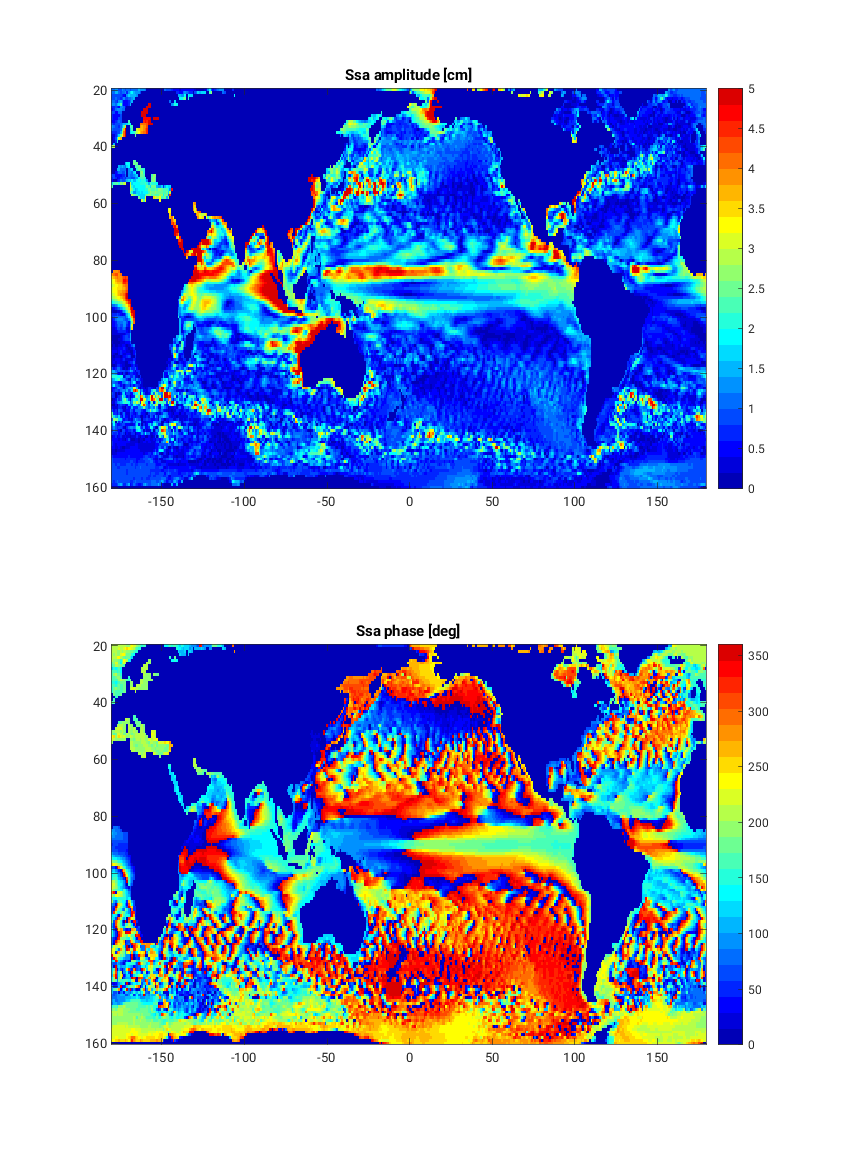

In [88]:
% ----------------- Start figure
width = 8;                        
height = 11.0;

figure('PaperUnits',           'centimeters', ...
    'DefaultAxesfontname',  'arial', ...
    'DefaultAxesfontsize',  10, ...
    'PaperPosition',        [0 0 width height], ...
    'color',                'white',...
    'papersize',            [width, height]);
set(gcf,'Position',[100 50 0.8*100*width 0.8*100*height]);
    
subplot(2,1,1)
imagesc(lonv,90-latv,sA_amp.*100)
set(gca,'colormap',mycmap_amp)
caxis([0 5])
colorbar
title('Ssa amplitude [cm]')
%ylabel('Co-latitude [°]')

subplot(2,1,2)
imagesc(lonv,90-latv,sA_pha*180/pi)
set(gca,'colormap',mycmap_amp)
caxis([0 360])
colorbar
title('Ssa phase [deg]')
%ylabel('Co-latitude [°]')


% ---> Save figure as seen on screen
oname = './Figures/Sa_OBP_GSFC_2002-2021';
set(gcf,'PaperPositionMode','auto')
set(gcf, 'InvertHardcopy', 'off')
% print(oname,'-dpng','-r200')



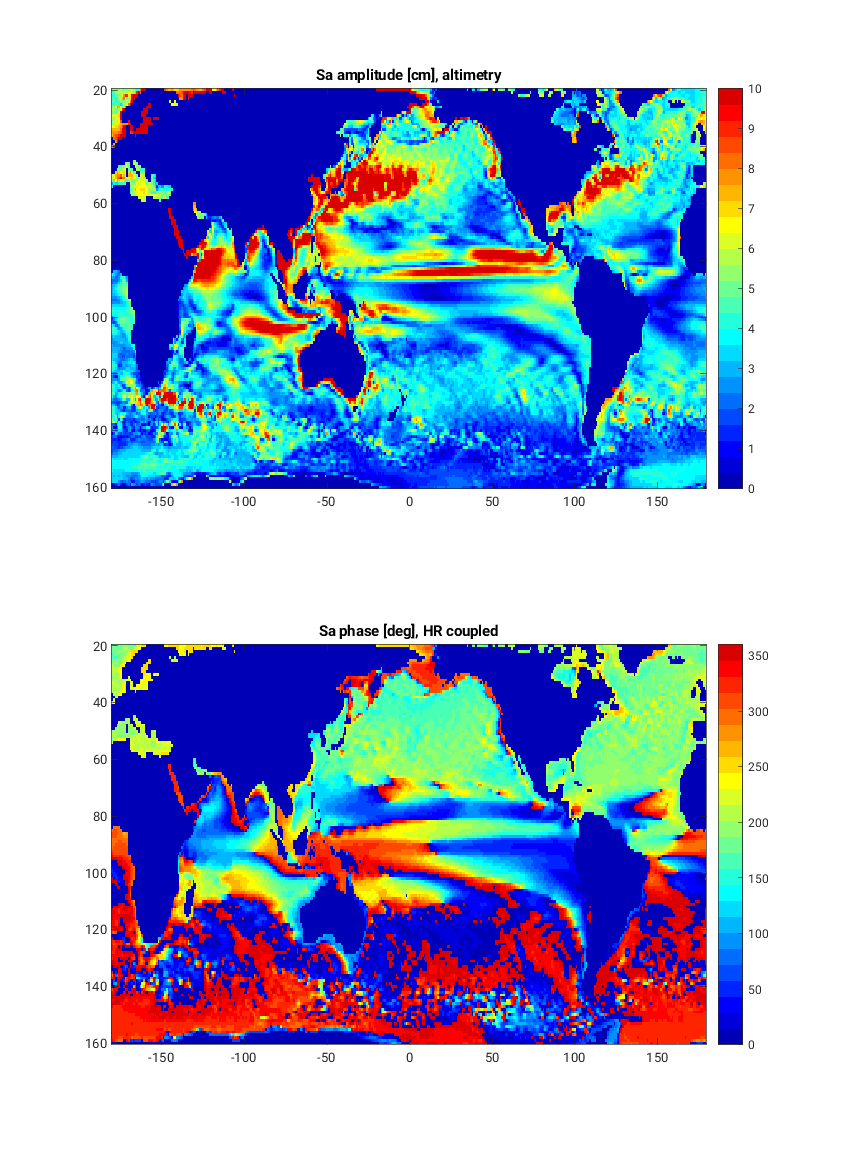

In [89]:
% ----------------- Start figure
width = 8;                        
height = 11.0;

figure('PaperUnits',           'centimeters', ...
    'DefaultAxesfontname',  'arial', ...
    'DefaultAxesfontsize',  10, ...
    'PaperPosition',        [0 0 width height], ...
    'color',                'white',...
    'papersize',            [width, height]);
set(gcf,'Position',[100 50 0.8*100*width 0.8*100*height]);
    
subplot(2,1,1)
imagesc(lonv,90-latv,SA_amp.*100)
set(gca,'colormap',mycmap_amp)
caxis([0 10])
colorbar
title('Sa amplitude [cm], altimetry')
%ylabel('Latitude [°]')

subplot(2,1,2)
imagesc(lonv,90-latv,SA_pha*180/pi)
set(gca,'colormap',mycmap_amp)
caxis([0 360])
colorbar
title('Sa phase [deg], HR coupled')
%ylabel('Latitude [°]')


% ---> Save figure as seen on screen
oname = './Figures/Sa_OBP_GSFC_2002-2021';
set(gcf,'PaperPositionMode','auto')
set(gcf, 'InvertHardcopy', 'off')
% print(oname,'-dpng','-r200')



In [76]:
nccreate('ocean_LR_coupled_vernalequinox.nc','Sa','Dimensions',{'x',size(SA_amp,1),'y',size(SA_amp,2)})
nccreate('ocean_LR_coupled_vernalequinox.nc','Sa_pha','Dimensions',{'xx',size(SA_amp,1),'yy',size(SA_amp,2)})
nccreate('ocean_LR_coupled_vernalequinox.nc','Ssa','Dimensions',{'x',size(SA_amp,1),'y',size(SA_amp,2)})
nccreate('ocean_LR_coupled_vernalequinox.nc','Ssa_pha','Dimensions',{'xx',size(SA_amp,1),'yy',size(SA_amp,2)})

In [91]:
ncwrite('ocean_HR_coupled_vernalequinox.nc','Sa',SA_amp)
ncwrite('ocean_HR_coupled_vernalequinox.nc','Sa_phase',SA_pha)
ncwrite('ocean_HR_coupled_vernalequinox.nc','Ssa',sA_amp)
ncwrite('ocean_HR_coupled_vernalequinox.nc','Ssa_pha',sA_pha)

In [3]:
ncdisp('ocean_alt_vernalequinox.nc')

Source:
           /glade/u/home/carmined/ocean_alt_vernalequinox.nc
Format:
           netcdf4_classic
Dimensions:
           x  = 141
           y  = 360
           xx = 141
           yy = 360
Variables:
    Sa      
           Size:       141x360
           Dimensions: x,y
           Datatype:   double
    Sa_phase
           Size:       141x360
           Dimensions: xx,yy
           Datatype:   double
    Ssa     
           Size:       141x360
           Dimensions: x,y
           Datatype:   double
    Ssa_pha 
           Size:       141x360
           Dimensions: xx,yy
           Datatype:   double


In [42]:
ncdisp('ocean_LR_FOSI_vernalequinox.nc')

Source:
           /glade/u/home/carmined/ocean_LR_FOSI_vernalequinox.nc
Format:
           netcdf4_classic
Dimensions:
           x  = 141
           y  = 360
           xx = 141
           yy = 360
Variables:
    Sa     
           Size:       141x360
           Dimensions: x,y
           Datatype:   double
    Sa_pha 
           Size:       141x360
           Dimensions: xx,yy
           Datatype:   double
    Ssa    
           Size:       141x360
           Dimensions: x,y
           Datatype:   double
    Ssa_pha
           Size:       141x360
           Dimensions: xx,yy
           Datatype:   double


In [69]:
ncdisp('ocean_LR_coupled_vernalequinox.nc')

Error using internal.matlab.imagesci.nc/openToRead (line 1299)
Unable to open file "ocean_LR_coupled_vernalequinox.nc".

Error in internal.matlab.imagesci.nc (line 124)
                    this.openToRead();
                    ^^^^^^^^^^^^^^^^^
Error in ncdisp (line 71)
ncObj   = internal.matlab.imagesci.nc(ncFile);
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



In [88]:
D1= ncread('ocean_LR_coupled_vernalequinox.nc','Sa');
D2= ncread('ocean_LR_coupled_vernalequinox.nc','Sa_pha');
D3= ncread('ocean_LR_coupled_vernalequinox.nc','Ssa');
D4= ncread('ocean_LR_coupled_vernalequinox.nc','Ssa_pha');

DD= ncread('ocean_alt.nc','Sa');

mcp = customcolormap([0 .25 .5 .75 1], {'#9d0142','#f66e45','#ffffbb','#65c0ae','#5e4f9f'});

mycmap_pha = flipud(copper(25));

D1(DD<6.2487e-15)=NaN;
D2(DD<6.2487e-15)=NaN;
D3(DD<6.2487e-15)=NaN;
D4(DD<6.2487e-15)=NaN;

lon = ncread('alt_sla_1x1_93_18.nc','lon');
lat = ncread('alt_sla_1x1_93_18.nc','lat');

In [97]:
%differences

D1= ncread('ocean_HR_FOSI_vernalequinox.nc','Sa');
D2= ncread('ocean_HR_FOSI_vernalequinox.nc','Sa_pha');
D3= ncread('ocean_LR_FOSI_vernalequinox.nc','Sa');
D4= ncread('ocean_LR_FOSI_vernalequinox.nc','Sa_pha');

DD= ncread('ocean_alt.nc','Sa');

R1=D1-D3;
R2=D2-D4;

mcp = customcolormap([0 .25 .5 .75 1], {'#9d0142','#f66e45','#ffffbb','#65c0ae','#5e4f9f'});

mycmap_pha = flipud(copper(25));

R1(DD<6.2487e-15)=NaN;
R2(DD<6.2487e-15)=NaN;


lon = ncread('alt_sla_1x1_93_18.nc','lon');
lat = ncread('alt_sla_1x1_93_18.nc','lat');


cbh = 

  ColorBar with properties:

    Location: 'eastoutside'
      Limits: [-26.6942 19.6716]
    FontSize: 9
    Position: [0.9289 0.0500 0.0214 0.9125]
       Units: 'normalized'

  Use GET to show all properties



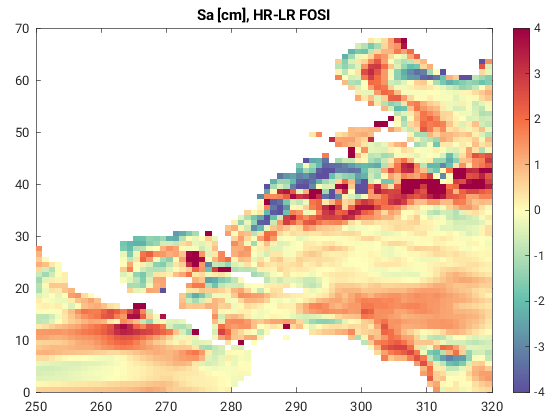

In [98]:
figure
t = tiledlayout(1,1,'TileSpacing','Compact','Padding','Compact');


nexttile
h = pcolor(lon,lat, R1.*100);
%H=colormap(ax(2),'jet');  %copper jet pink
set(h, 'EdgeColor', 'none');
cbh=colorbar
%cbh.Ticks = linspace(0,0.1,6)
%cbh.TickLabels = num2cell(0:2:10);
set(h, 'EdgeColor', 'none');

%xlim([100 200]) %Kuroshio, Australia
%ylim([-40 70])

xlim([250 320]) %GS
ylim([0 70])


%xlim([100 300]) %tropics
%ylim([-40 40])


%xlim([0 140]) %Indian Ocean
%ylim([-40 70])


caxis([-4, 4]);
title('Sa [cm], HR-LR FOSI')
%ylabel('Latitude');
%xlabel('Longitude');

mycolormap = customcolormap([0 .25 .5 .75 1], {'#9d0142','#f66e45','#ffffbb','#65c0ae','#5e4f9f'});
colormap(mycolormap);

%hold on
%p=scatter3(M(:,3),M(:,2),M(:,5),[], M(:,5), 'filled')
%p.MarkerEdgeColor = [0 0 0];
%p.SizeData = 12;


saveas(gcf,'Figure1a.png')



cbh = 

  ColorBar with properties:

    Location: 'eastoutside'
      Limits: [-359.7502 359.8195]
    FontSize: 9
    Position: [0.9200 0.0500 0.0214 0.9125]
       Units: 'normalized'

  Use GET to show all properties



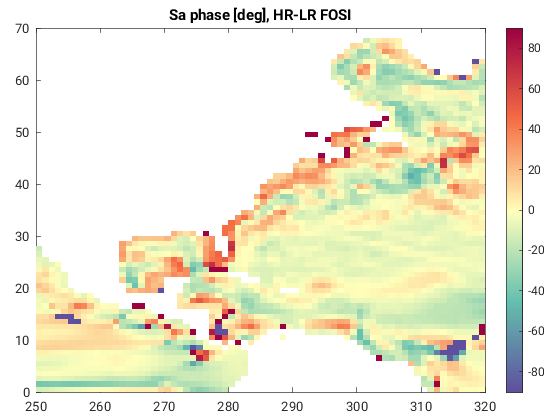

In [99]:
figure
t = tiledlayout(1,1,'TileSpacing','Compact','Padding','Compact');


nexttile
h = pcolor(lon,lat, R2.*180/pi);
%H=colormap(ax(2),'jet');  %copper jet pink
set(h, 'EdgeColor', 'none');
cbh=colorbar
%cbh.Ticks = linspace(0,0.1,6)
%cbh.TickLabels = num2cell(0:2:10);
set(h, 'EdgeColor', 'none');

%xlim([100 200]) %Kuroshio, Australia
%ylim([-40 70])

%xlim([0 140]) %Indian Ocean
%ylim([-40 70])

xlim([250 320]) %GS
ylim([0 70])

%xlim([100 300]) %tropics
%ylim([-40 40])

caxis([-90, 90]);
title('Sa phase [deg], HR-LR FOSI')
%ylabel('Latitude');
%xlabel('Longitude');

mycolormap = customcolormap([0 .25 .5 .75 1], {'#9d0142','#f66e45','#ffffbb','#65c0ae','#5e4f9f'});
colormap((mycolormap));



%hold on
%p=scatter3(M(:,3),M(:,2),M(:,5),[], M(:,5), 'filled')
%p.MarkerEdgeColor = [0 0 0];
%p.SizeData = 12;


saveas(gcf,'Figure11a.png')


cbh = 

  ColorBar with properties:

    Location: 'eastoutside'
      Limits: [0 9.4764]
    FontSize: 9
    Position: [0.9414 0.0500 0.0214 0.9125]
       Units: 'normalized'

  Use GET to show all properties



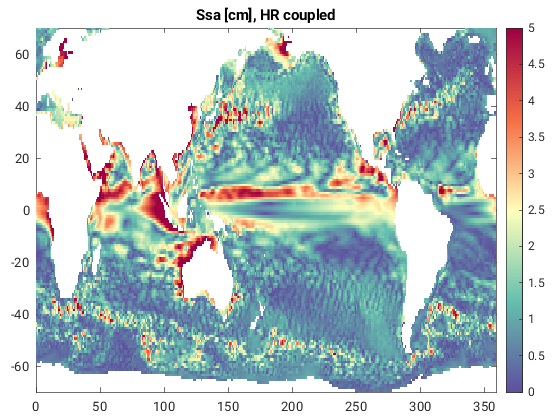

In [96]:
figure
t = tiledlayout(1,1,'TileSpacing','Compact','Padding','Compact');


nexttile
h = pcolor(lon,lat, D3.*100);
%H=colormap(ax(2),'jet');  %copper jet pink
set(h, 'EdgeColor', 'none');
cbh=colorbar
%cbh.Ticks = linspace(0,0.1,6)
%cbh.TickLabels = num2cell(0:2:10);
set(h, 'EdgeColor', 'none');

%xlim([-140 0]) %West coast
%ylim([-70 70])

%xlim([50 200]) %Australia
%ylim([-40 40])

%xlim([-140 -40]) %USA
%ylim([20 70])

%xlim([-80 -20]) %chile
%ylim([-70 0])

caxis([0, 5]);
title('Ssa [cm], HR coupled')
%ylabel('Latitude');
%xlabel('Longitude');

mycolormap = customcolormap([0 .25 .5 .75 1], {'#9d0142','#f66e45','#ffffbb','#65c0ae','#5e4f9f'});
colormap(mycolormap);

%hold on
%p=scatter3(M(:,3),M(:,2),M(:,5),[], M(:,5), 'filled')
%p.MarkerEdgeColor = [0 0 0];
%p.SizeData = 12;


saveas(gcf,'Figure1a.png')



cbh = 

  ColorBar with properties:

    Location: 'eastoutside'
      Limits: [0.0092 359.9953]
    FontSize: 9
    Position: [0.9236 0.0500 0.0214 0.9125]
       Units: 'normalized'

  Use GET to show all properties



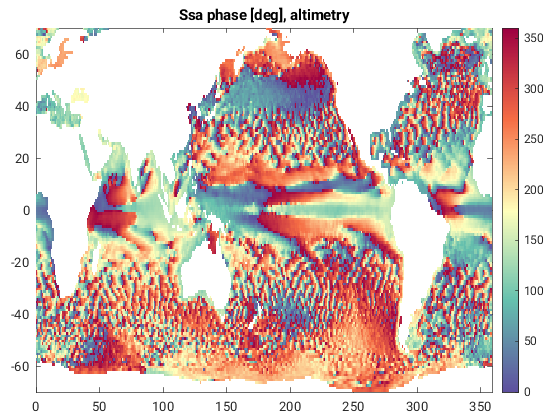

In [39]:
figure
t = tiledlayout(1,1,'TileSpacing','Compact','Padding','Compact');


nexttile
h = pcolor(lon,lat, D4*180/pi);
%H=colormap(ax(2),'jet');  %copper jet pink
set(h, 'EdgeColor', 'none');
cbh=colorbar
%cbh.Ticks = linspace(0,0.1,6)
%cbh.TickLabels = num2cell(0:2:10);
set(h, 'EdgeColor', 'none');

%xlim([-140 0]) %West coast
%ylim([-70 70])

%xlim([50 200]) %Australia
%ylim([-40 40])

%xlim([-140 -40]) %USA
%ylim([20 70])

%xlim([-80 -20]) %chile
%ylim([-70 0])

caxis([0, 360]);
title('Ssa phase [deg], altimetry')
%ylabel('Latitude');
%xlabel('Longitude');

mycolormap = customcolormap([0 .25 .5 .75 1], {'#9d0142','#f66e45','#ffffbb','#65c0ae','#5e4f9f'});
colormap(mycolormap);

%hold on
%p=scatter3(M(:,3),M(:,2),M(:,5),[], M(:,5), 'filled')
%p.MarkerEdgeColor = [0 0 0];
%p.SizeData = 12;


saveas(gcf,'Figure1a.png')

In [160]:
clear all

DD= ncread('ocean_alt_vernalequinox.nc','Sa_phase');
DDD= ncread('ocean_HR_coupled_vernalequinox.nc','Sa_phase');

DDDD= ncread('ocean_alt.nc','Sa');

D=DD-DDD;

D(DDDD<6.2487e-15)=NaN;

lon = ncread('alt_sla_1x1_93_18.nc','lon');
lat = ncread('alt_sla_1x1_93_18.nc','lat');


cbh = 

  ColorBar with properties:

    Location: 'eastoutside'
      Limits: [-359.4461 359.7648]
    FontSize: 9
    Position: [0.9200 0.0500 0.0214 0.9125]
       Units: 'normalized'

  Use GET to show all properties



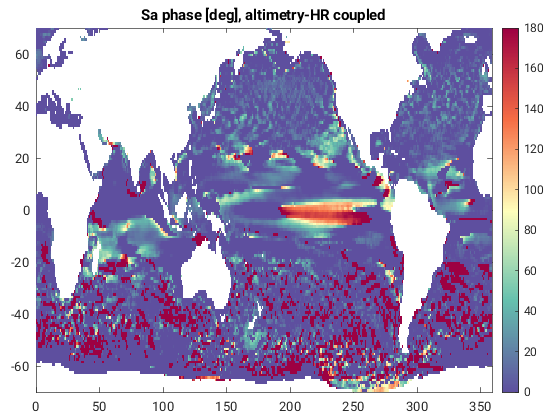

In [162]:
figure
t = tiledlayout(1,1,'TileSpacing','Compact','Padding','Compact');


nexttile
h = pcolor(lon,lat, D*180/pi);
%H=colormap(ax(2),'jet');  %copper jet pink
set(h, 'EdgeColor', 'none');
cbh=colorbar
%cbh.Ticks = linspace(0,0.1,6)
%cbh.TickLabels = num2cell(0:2:10);
set(h, 'EdgeColor', 'none');

%xlim([-140 0]) %West coast
%ylim([-70 70])

%xlim([50 200]) %Australia
%ylim([-40 40])

%xlim([-140 -40]) %USA
%ylim([20 70])

%xlim([-80 -20]) %chile
%ylim([-70 0])

caxis([0, 180]);
title('Sa phase [deg], altimetry-HR coupled')
%ylabel('Latitude');
%xlabel('Longitude');

mycolormap = customcolormap([0 .25 .5 .75 1], {'#9d0142','#f66e45','#ffffbb','#65c0ae','#5e4f9f'});
colormap(mycolormap);

%hold on
%p=scatter3(M(:,3),M(:,2),M(:,5),[], M(:,5), 'filled')
%p.MarkerEdgeColor = [0 0 0];
%p.SizeData = 12;


saveas(gcf,'Figure1a.png')


cbh = 

  ColorBar with properties:

    Location: 'eastoutside'
      Limits: [-627.3518 627.9081]
    FontSize: 9
    Position: [0.9200 0.0500 0.0214 0.9125]
       Units: 'normalized'

  Use GET to show all properties



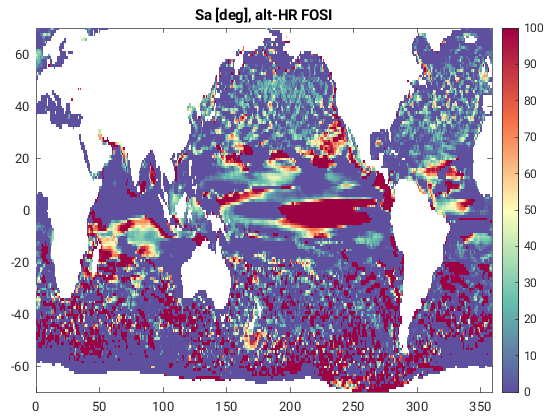

In [131]:
figure
t = tiledlayout(1,1,'TileSpacing','Compact','Padding','Compact');


nexttile
h = pcolor(lon, lat, D.*100);
%H=colormap(ax(2),'jet');  %copper jet pink
set(h, 'EdgeColor', 'none');
cbh=colorbar
%cbh.Ticks = linspace(0,0.1,6)
%cbh.TickLabels = num2cell(0:2:10);
set(h, 'EdgeColor', 'none');

%xlim([-140 0]) %West coast
%ylim([-70 70])

%xlim([50 200]) %Australia
%ylim([-40 40])

%xlim([-140 -40]) %USA
%ylim([20 70])

%xlim([-80 -20]) %chile
%ylim([-70 0])

caxis([0, 100]);
title('Sa [deg], alt-HR FOSI')
%ylabel('Latitude');
%xlabel('Longitude');

mycolormap = customcolormap([0 .25 .5 .75 1], {'#9d0142','#f66e45','#ffffbb','#65c0ae','#5e4f9f'});
colormap(mycolormap);

%hold on
%p=scatter3(M(:,3),M(:,2),M(:,5),[], M(:,5), 'filled')
%p.MarkerEdgeColor = [0 0 0];
%p.SizeData = 12;


saveas(gcf,'Figure2a.png')



cbh = 

  ColorBar with properties:

    Location: 'eastoutside'
      Limits: [-1.0463e+03 1]
    FontSize: 9
    Position: [0.9111 0.0500 0.0214 0.9125]
       Units: 'normalized'

  Use GET to show all properties



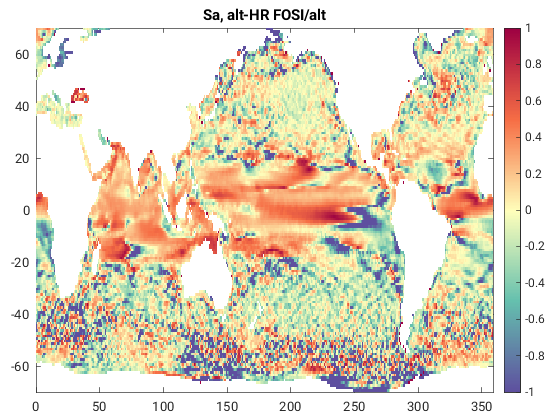

In [120]:
figure
t = tiledlayout(1,1,'TileSpacing','Compact','Padding','Compact');


nexttile
h = pcolor(lon, lat, D./DD);
%H=colormap(ax(2),'jet');  %copper jet pink
set(h, 'EdgeColor', 'none');
cbh=colorbar
%cbh.Ticks = linspace(0,0.1,6)
%cbh.TickLabels = num2cell(0:2:10);
set(h, 'EdgeColor', 'none');

%xlim([-140 0]) %West coast
%ylim([-70 70])

%xlim([50 200]) %Australia
%ylim([-40 40])

%xlim([-140 -40]) %USA
%ylim([20 70])

%xlim([-80 -20]) %chile
%ylim([-70 0])

caxis([-1, 1]);
title('Sa, alt-HR FOSI/alt')
%ylabel('Latitude');
%xlabel('Longitude');

mycolormap = customcolormap([0 .25 .5 .75 1], {'#9d0142','#f66e45','#ffffbb','#65c0ae','#5e4f9f'});
colormap(mycolormap);

%hold on
%p=scatter3(M(:,3),M(:,2),M(:,5),[], M(:,5), 'filled')
%p.MarkerEdgeColor = [0 0 0];
%p.SizeData = 12;


saveas(gcf,'Figure2a.png')
